# Fisher's Linear Discriminant

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 200

In [2]:
df = pd.read_csv('dataset_FLD.csv', names = ['feature1', 'feature2', 'feature3', 'target'])
df.head()

,feature1,feature2,feature3,target
0,-6.672418,-1.206198,-1.081050,0
1,1.675598,0.614994,-0.971600,0
2,-4.039058,0.335102,0.544618,1
3,0.793526,-0.235277,0.551771,1
4,3.820273,-0.274691,0.454743,1


In [3]:
#Dividing Dataset into 2 classes
pClass = df[df.iloc[:, -1] == 1].to_numpy()
nClass = df[df.iloc[:, -1] == 0].to_numpy()



X_p = pClass[:, :-1]
y_p = pClass[:, -1].reshape(-1, 1)

X_n = nClass[:, :-1]
y_n = nClass[:, -1].reshape(-1, 1)

# Complete set
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy().reshape(-1, 1)

In [4]:
X_p.shape, y_p.shape, X_n.shape, y_n.shape

((500, 3), (500, 1), (500, 3), (500, 1))

In [5]:
neg_df, pos_df = [features for c, features in df.groupby('target')]

X_pos = pos_df.drop(['target'], axis=1).to_numpy()
X_neg = neg_df.drop(['target'], axis=1).to_numpy()

dataset = df.to_numpy()

_X = dataset[:, :3]
_y = dataset[:, -1].reshape(-1, 1)

In [6]:
X_p.shape, X_n.shape, _X.shape, _y.shape

((500, 3), (500, 3), (1000, 3), (1000, 1))

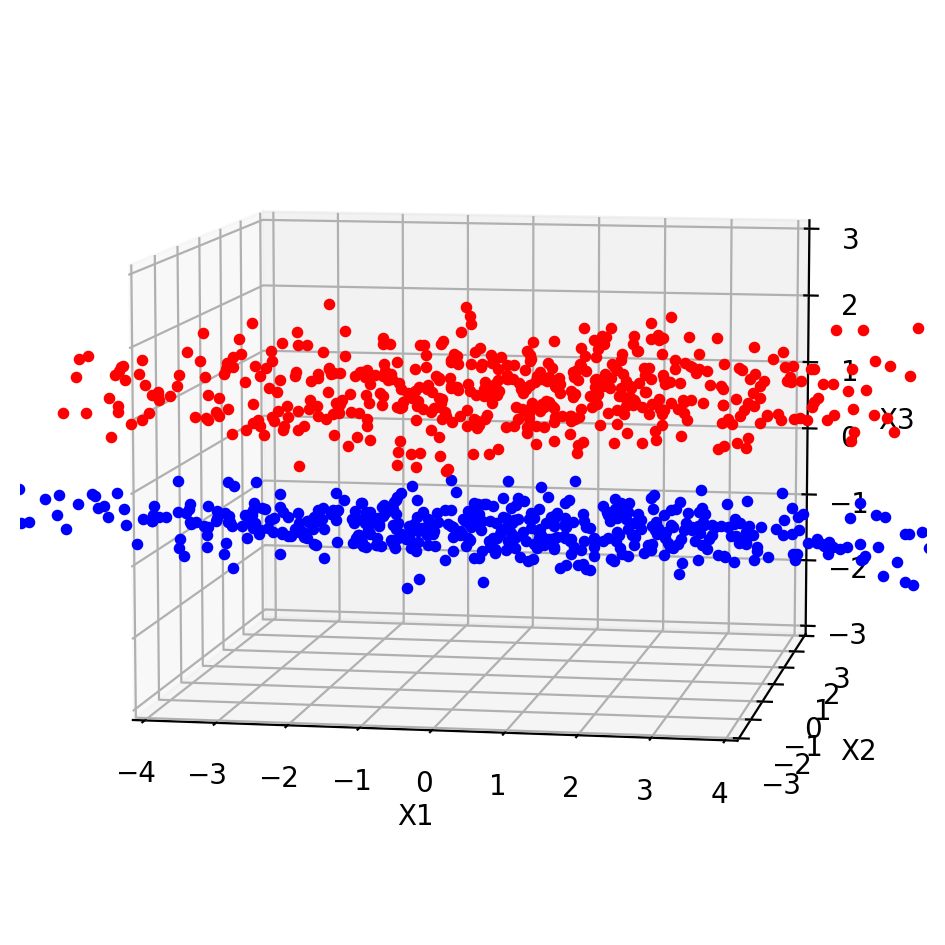

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')

ax.scatter(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], s=10, color=[1, 0, 0], depthshade=False)
ax.scatter(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], s=10, color=[0, 0, 1], depthshade=False)

ax.set_xlim(-4, 4)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)
ax.view_init(8, -80)

## Terms

$ \text{S}_{\text{w}} $: Total within class covariance matrix

$ \text{M}_{\text{1}} $: Mean Vector of Class `1` (Positive class)

$ \text{M}_{\text{2}} $: Mean Vector of Class `0` (Negative class)

$ \text{w} $: Weight Vector

On solving the conditions we get the weight vector proportional to :


<font size = "4">$$ w \propto S_w^{-1} (M_1 - M_2) $$</font>

In [8]:
def getW(X_p, X_n):
    M_p = np.mean(X_p, axis=0)
    M_n = np.mean(X_n, axis=0)
    
    C1 = np.cov(X_p.T)
    C2 = np.cov(X_n.T)
    
    #Total within class covariance
    Sw = np.add(C1, C2)
    Sw_in = np.linalg.inv(Sw)
    
    W = np.dot(Sw_in, (M_p - M_n))
    
    #Normalizing
    W_n = W / np.linalg.norm(W)
    return W_n

In [9]:
def getGaussianStats(X, W):
    D = np.dot(W, X.T)
    mean = np.mean(D)
    std = np.std(D)
    var = np.var(D)
    
    stats = {'mean': mean, 'std': std, 'var': var}
    return stats

## Finding intersecting point

<font size = "4">Let the Gaussian Distribution of the classes : <code>0</code> and <code>1</code></font> be :


<font size = "4">$y_0 = \frac{1}{\sqrt{2\pi\sigma^{2}_0}} e^{\frac{-(X - \mu_0)^2}{2\sigma_0}}$</font>


<font size = "4">$y_1 = \frac{1}{\sqrt{2\pi\sigma^{2}_1}} e^{\frac{-(X - \mu_1)^2}{2\sigma_1}}$</font>

On solving for the intersection point we get the quadratic equation as - 
    
<font size = "4">$(\frac{1}{\sigma_1^{2}} - \frac{1}{\sigma_0^{2}})x^2 + 2(\frac{\mu_1}{\sigma_1^{2}} - \frac{\mu_0}{\sigma_0^{2}})x + \frac{\mu_0^2}{\sigma_0^2} - \frac{\mu_1^2}{\sigma_1^2} + \log(\frac{\mu_0}{\mu_1}) = 0$ </font>

Solving the above quadratic equation we will get the intersection point.

In [10]:
def getIntersectionPoint(X_p, X_n, W):
    pStats = getGaussianStats(X_p, W)
    pMean, pVar = pStats['mean'], pStats['var']
    nStats = getGaussianStats(X_n, W)
    nMean, nVar = nStats['mean'], nStats['var']
    
    a = (1 / pVar) - (1 / nVar)
    b = 2 * (pMean/pVar - nMean/nVar)
    c = (((nMean ** 2)/nVar - (pMean ** 2)/pVar) + np.log(nVar/pVar))
    
    roots = np.roots([a, b, c])
    return roots[1], pStats, nStats

In [11]:
def predictions(X, W, threshold):
    projections = np.dot(W, X.T).reshape(-1, 1)
    
    P = (projections >= threshold).astype(int).reshape(-1, 1)
    return P, projections

In [12]:
def accuracy(A, P):
    C = 0
    W = 0
    for i in range(len(A)):
        if(A[i] == P[i]):
            C += 1
        else:
            W += 1
    acc = C / (C + W)
    return acc        

In [13]:
def getGD_curve(X, W, GD):
    mean = GD['mean']
    var = GD['var']
    Z = -((X - mean) ** 2)/(2 * var)
    Y = (1 / np.sqrt( 2 * np.pi * var)) * np.exp(Z)
    return X, Y

In [14]:
def GD_plot(W, threshold, pStats, nStats):
    X = np.linspace(-2, 2.5, 1000)
    X_pos, Y_pos = getGD_curve(X, W, pStats)
    X_neg, Y_neg = getGD_curve(X, W, nStats)
    plt.plot(X_pos, Y_pos, '-', color = 'r', label = 'Class 1')
    plt.plot(X_neg, Y_neg, '-', color = 'b', label = 'Class 0')
    X_t, y_t = getGD_curve([threshold], W, pStats)
    plt.plot(X_t, y_t, '.', color = 'black', label = 'Threshold', markersize = 10)
    plt.title('Normal Distributions')
    plt.legend(loc = 'upper right')
    plt.show()
    
    print(f"Class 1 Stats (Positive class) :")
    print(f"Mean : {pStats['mean']}")
    print(f"Std Deviation : {pStats['std']}")
    print(f"variance : {pStats['var']}")
    print("\n\n")
    print(f"Class 0 Stats (Negative class):")
    print(f"Mean : {nStats['mean']}")
    print(f"Std Deviation : {nStats['std']}")
    print(f"variance : {nStats['var']}")

In [15]:
def projections_1D(P, y, threshold, pStats, nStats):
    points = pd.DataFrame(np.concatenate((P, y), axis = 1))
    
    pPoints = points.loc[points[1] == 1][[0]]
    nPoints = points.loc[points[1] == 0][[0]]
    
    plt.plot(pPoints, np.ones(pPoints.shape), '.', color = 'r', label = 'Class 1')
    plt.plot(nPoints, np.ones(nPoints.shape), '.', color = 'b', label = 'Class 0')
    plt.plot([threshold], [1], '.', color = 'black', label = 'Threshold', markersize=10)
    plt.plot([pStats['mean']], [1], 'x', color = 'black', label = "Class 1 mean", markersize = 8)
    plt.plot([nStats['mean']], [1], 'x', color = 'black', label = "Class 0 mean", markersize = 8)
    
    plt.title('Projections onto vector W')
    plt.legend(loc = 'upper right')
    plt.show()

In [16]:
def FLD(X_p, X_n, y_p):
    W = getW(X_p, X_n)
    
    threshold, pStats, nStats = getIntersectionPoint(X_p, X_n, W)
    P, projections = predictions(X, W, threshold)
    acc = accuracy(y, P)
    
    return W, projections, threshold, acc, pStats, nStats

In [17]:
W, projections, threshold, acc, pStats, nStats = FLD(X_p, X_n, y_p)


print(f"W (3D) : {W}")
print(f"Threshold value : {threshold}")
print(f"Accuracy : {acc * 100}%")

W (3D) : [-0.00655686 -0.01823739  0.99981218]
Threshold value : -0.30381959407288783
Accuracy : 99.9%


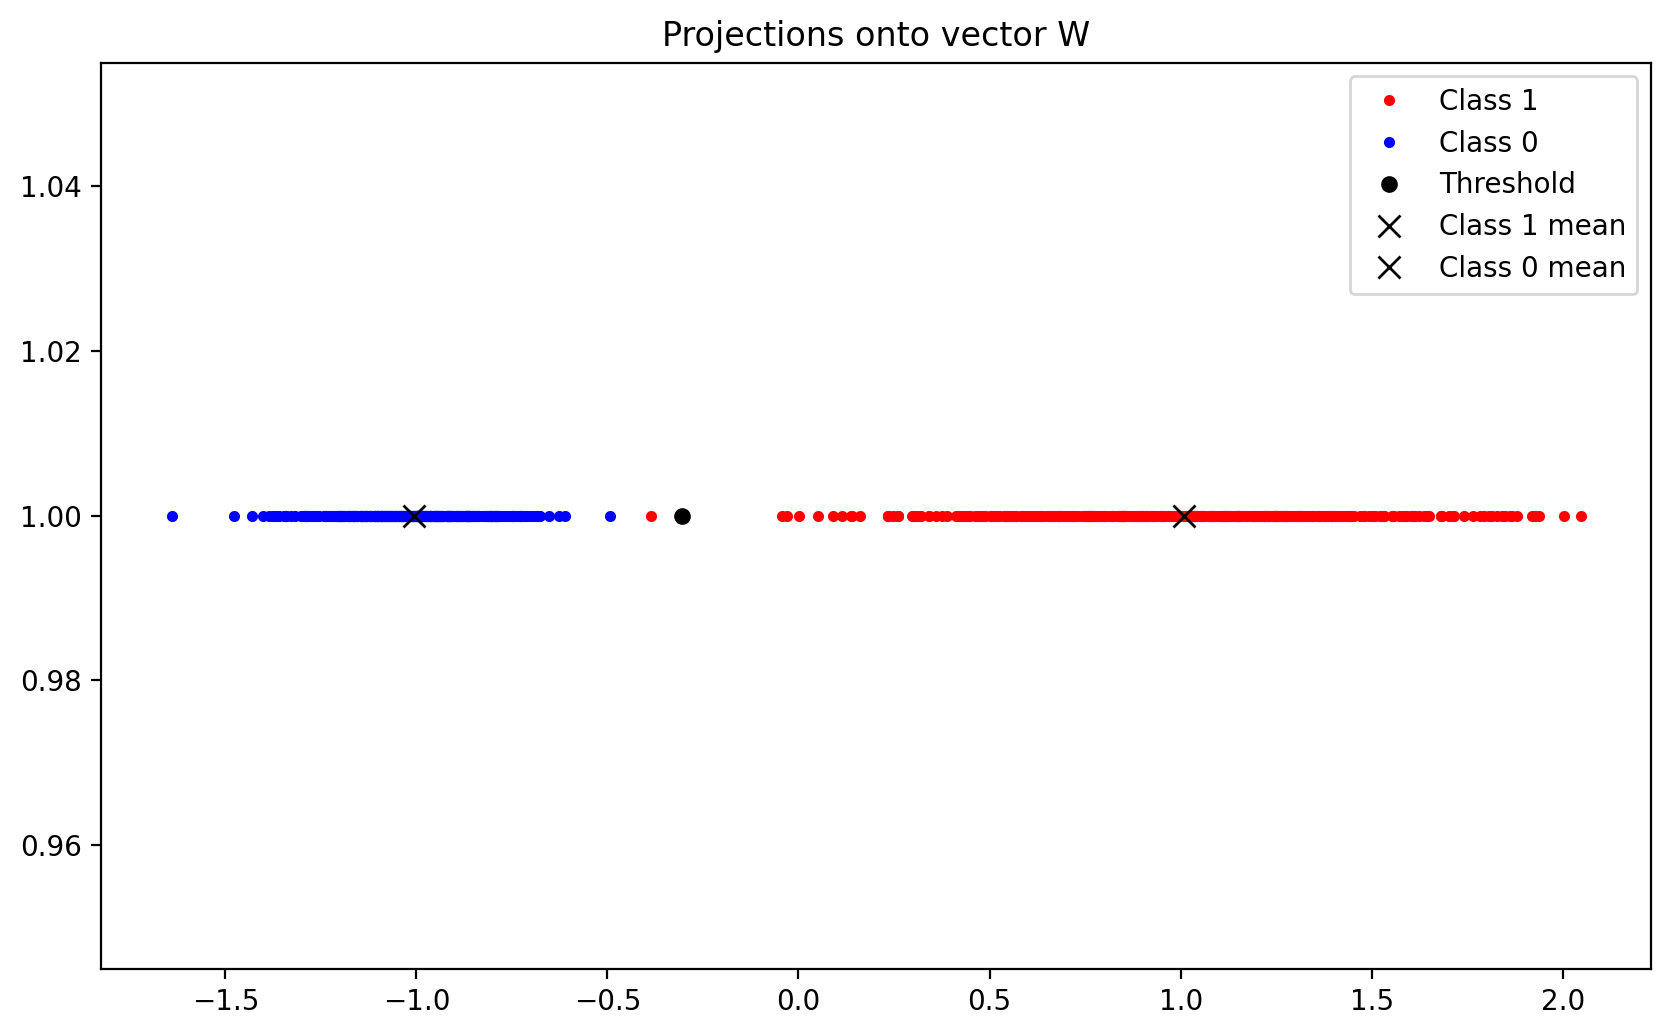

In [18]:
projections_1D(projections, y, threshold, pStats, nStats)


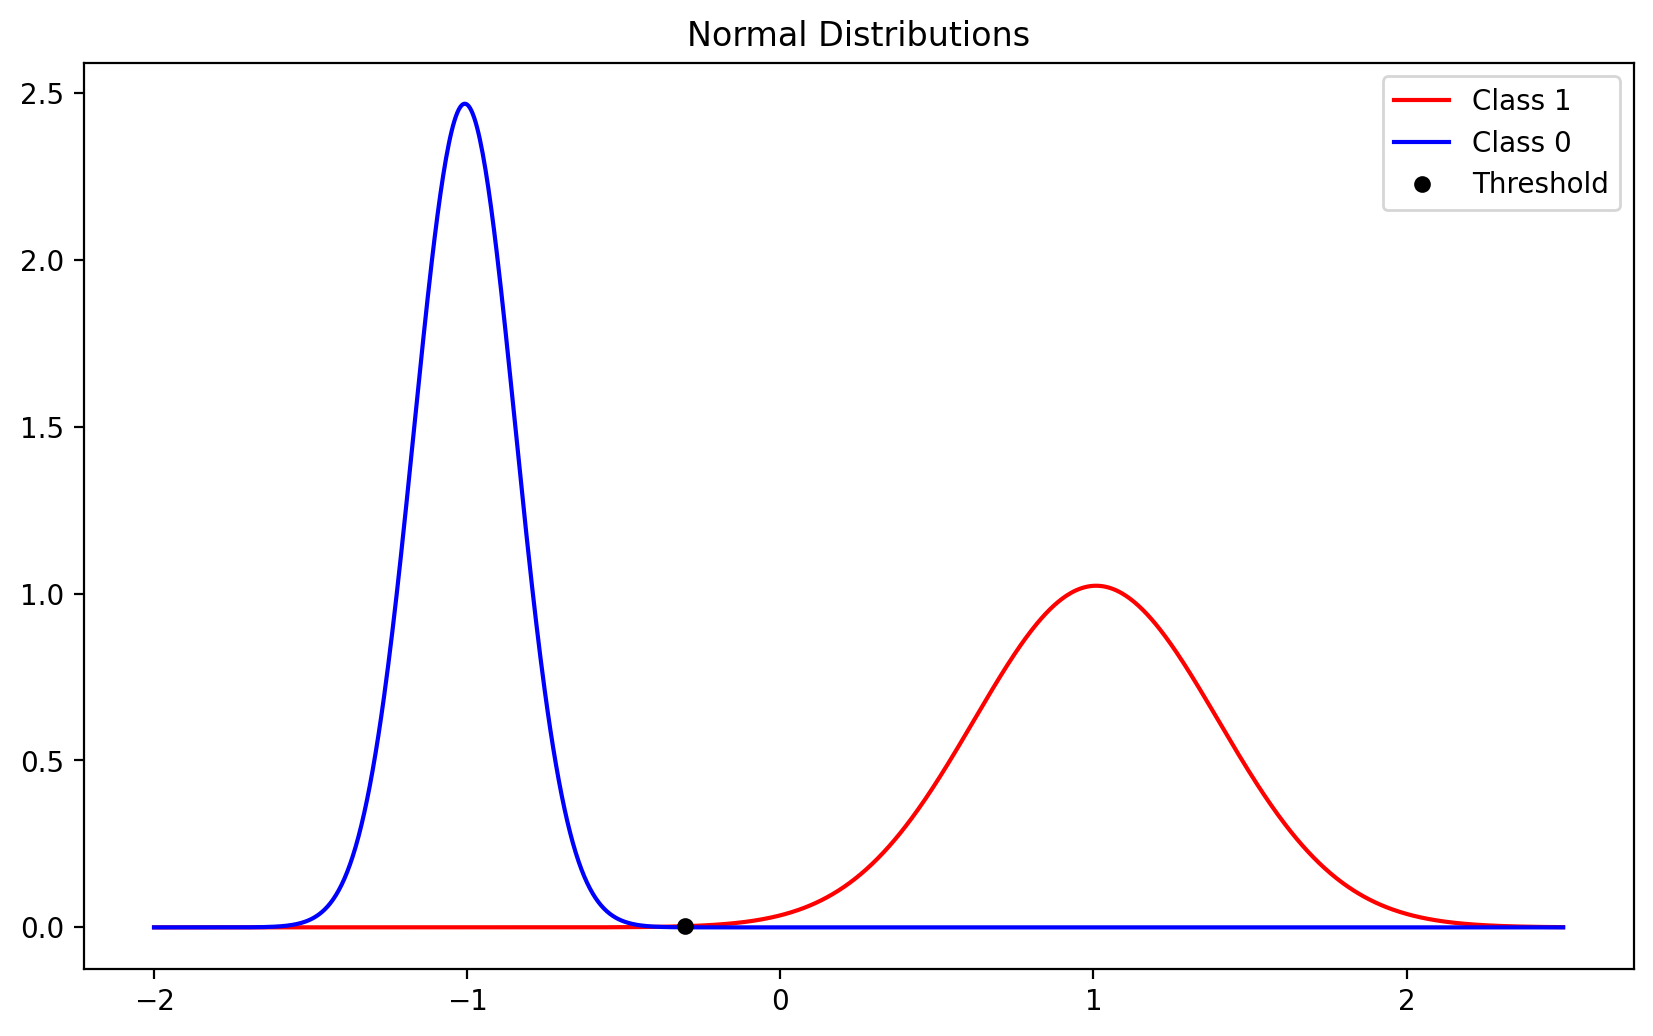

Class 1 Stats (Positive class) :
Mean : 1.0085714575861837
Std Deviation : 0.3898154645217035
variance : 0.1519560963802715



Class 0 Stats (Negative class):
Mean : -1.0074971533352852
Std Deviation : 0.16168139595107733
variance : 0.026140873796689043


In [19]:
GD_plot(W, threshold, pStats, nStats)

## Finding Discriminant Plane
Line passing through unit vector $\vec{W}$ will be passing throught 2 points i.e. (0, 0, 0) & $(w_1, w_2, w_3)$

Therefore the equation of line will be :
$$x = (w_1 - 0)t + 0$$
$$y = (w_2 - 0)t + 0$$
$$z = (w_3 - 0)t + 0$$

where $t\in\mathbb{R}$ be the parameter

Now this line will be the normal vector of the discriminant plane. Also the plane passes through the threshold point : $(x_t, y_t, z_t)$

Therefore equation of plane becomes -
$$w_1(x - x_t) + w_2(y - y_t) + w_3(z - z_t) = 0$$

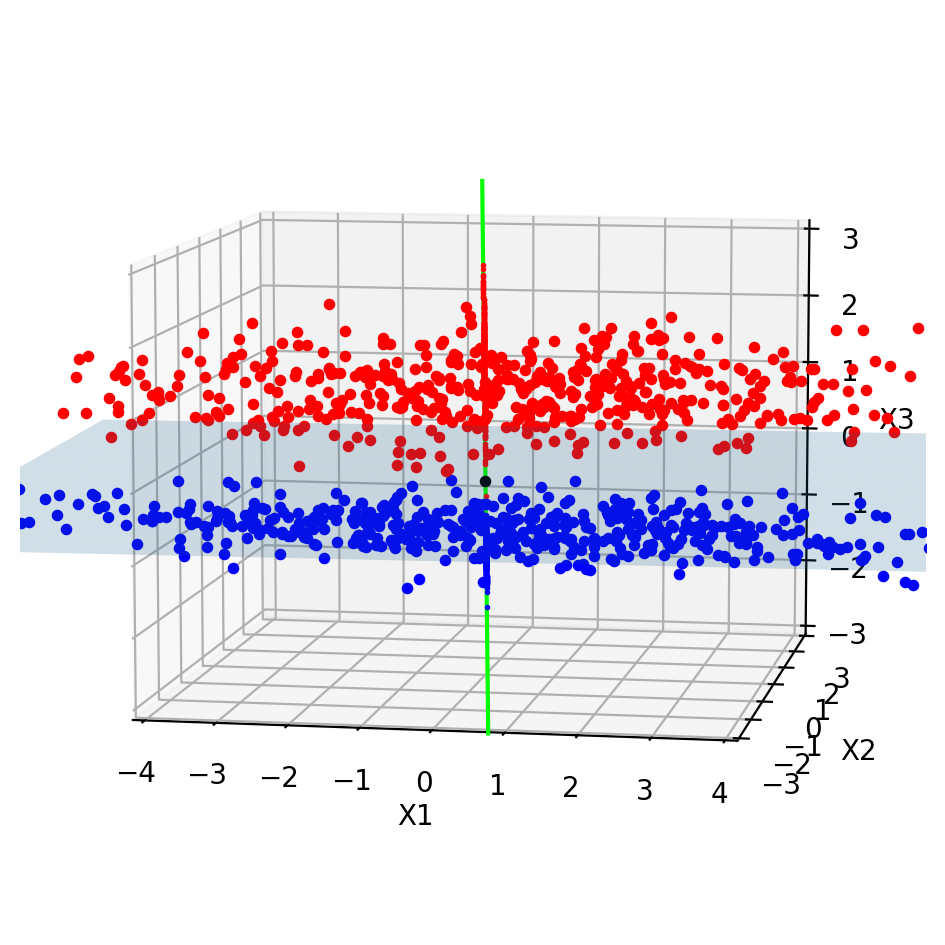

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')

ax.scatter(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], s=10, color=[1, 0, 0], depthshade=False)
ax.scatter(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], s=10, color=[0, 0, 1], depthshade=False)


#line = np.array([0, 0, 0])
#line = np.vstack((line, W))

#ax.plot(line[:, 0], line[:, 1], line[:, 2], color = 'black')

# Extended the commented line

x = W[0] * np.linspace(-4, 4, 100) 
y = W[1] * np.linspace(-4, 4, 100)
z = W[2] * np.linspace(-4, 4, 100)
ax.plot(x, y, z, color = 'lime')


# Projections 
W_r = W.reshape(1, -1)
X_pn = np.dot(W_r, X_pos.T) / np.linalg.norm(X_pos)
X_pn = X_pn.T * W * 1e2   # Scaled up to show properly in the plot

X_nn = np.dot(W_r, X_neg.T) / np.linalg.norm(X_neg)
X_nn = X_nn.T * W * 1e2  # Scaled up to show properly in th plot

ax.scatter(X_pn[:, 0], X_pn[:, 1], X_pn[:, 2], s=1, color=[1, 0, 0], depthshade=False)
ax.scatter(X_nn[:, 0], X_nn[:, 1], X_nn[:, 2], s=1, color=[0, 0, 1], depthshade=False)

X_t = W * threshold
ax.scatter(X_t[0], X_t[1], X_t[2], s = 10, color = 'black', depthshade = False)



# Equation of discriminant plane where unit vecotr W is normal vector
x, y = np.meshgrid(range(-7, 8), range(-5, 5))
z = W[2] * X_t[2] - (W[0] * (x - X_t[0]) + W[1] * (y - X_t[1]))
z = z / W[2]

ax.plot_surface(x, y, z, alpha = 0.2)

ax.set_xlim(-4, 4)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)


ax.view_init(8, -80)

plt.show()